In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
np.random.seed(42)

In [2]:
a=0.05
b=0.002
sigma_r = 0.02
c=0.4
k2=0.05
rho_inf=0.3

In [3]:
v = math.sqrt((1/c**2)-1-2*((rho_inf/c)-1))
sigma_1=c*sigma_r
sigma_2=v*sigma_1
rho_x = ((rho_inf/c)-1)/v
sig1_sq = sigma_1**2
sig2_sq = sigma_2**2

In [4]:
# Constants
notional_val = 50000000  # USD50 million
years = 10  # 10-year swap
coupons_per_year = 2  # Semi-annual payments

In [5]:
dT = 1/coupons_per_year
num_years = 10
num_steps_T = int (num_years/dT)
t_grid = [i for i in np.arange(0,num_years+dT,dT)]

In [6]:
def P_0_t(a,b,t):

    return math.exp(-a*t - (b*(t**2)/2))

def calc_hpar(notional=1):

    P_values = [P_0_t(a, b, t) for t in t_grid[1:]]

    return (1 - P_values[-1])/(sum(P_values) * dT)

In [7]:
h_par = calc_hpar()
h_par*100

5.9894224131521785

In [8]:
def C_t_T(k2,t,T):

    return np.array([[-(T-t)],[(math.exp(-k2 * (T - t)) - 1)/k2]])

def A_t_T(rho_x, sigma_1, sigma_2, k2, t, T):

    sig1_sq = sigma_1**2
    sig2_sq = sigma_2**2

    term_x = sig1_sq*t + (sig1_sq*sig2_sq*(rho_x**2)/(2*k2)) * (math.exp(2*k2*t) - 1)

    term_y = (rho_x*sig1_sq*sigma_2/k2) * (1 - math.exp(-k2*t)) + (rho_x*sig2_sq*sigma_1/(2*k2)) * (math.exp(k2*t) - math.exp(-k2*t))

    term_z = (1 + (rho_x**2)*sig1_sq) * (sig2_sq/(2*k2)) * (1 - math.exp(-2*k2*t))

    a_t_T = 0

    a_t_T += (term_x/2) * ((T - t)**2)

    a_t_T += term_y * ((T - t) / k2) * (1 - math.exp(-k2*(T-t)))

    a_t_T += (term_z/(k2**2)) * (0.5*math.exp(-2*k2*(T-t)) - math.exp(-k2*(T-t)) + 0.5)

    return -a_t_T

def P_t_T(a, b, rho_x, sigma_1, sigma_2, k2, dt, t, T, x):

    p_0_t = P_0_t(a, b, t)

    p_0_T = P_0_t(a, b, T)

    # Reconstitution Formula
    return (p_0_T/p_0_t) * math.exp(A_t_T(rho_x, sigma_1, sigma_2, k2, t, T) + C_t_T(k2, t, T).T@x)


In [9]:
def swapvalue(coupons, couponPeriods, x1, x2, dt, t, c_period, SwapNtl=1):
    swpval = {c:0 for c in coupons}
    x = np.array([x1,x2])
    p_0_t = P_0_t(a, b, t)

    PtTPrev = -10

    for i in range(1, len(couponPeriods)):

        if t >= couponPeriods[i]:
            continue

        if PtTPrev == -10:
            PtTPrev = P_t_T(a, b, rho_x, sigma_1, sigma_2, k2, dt, t, couponPeriods[i-1], x.T)

        PtT = P_t_T(a, b, rho_x, sigma_1, sigma_2, k2, dt, t, couponPeriods[i], x.T)

        for c in coupons:
            swpval[c] += PtTPrev - PtT*(1+c*c_period) # negative of Receiver Swap value

        PtTPrev = PtT

    for c in coupons:
        swpval[c] *= SwapNtl

    # Returning both V(t) and PV(t)
    return swpval, {c:(swpval[c]*p_0_t) for c in coupons}

In [10]:
couponPeriods=[0.0, 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ,
5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5, 10. ]

In [11]:
num_paths = 30000
T = 10
dt = 1/48
num_steps = int(T/dt)
time_grid = [i * dt for i in range(num_steps + 1)]

In [12]:
# Parameters
num_years = T
num_steps = int(num_years/dt)

kappa = np.array([[0, 0], [0, 0.05]])  # Define your kappa matrix
sigma_x = np.array([[sigma_1, 0], [0, sigma_2]])  # Define your sigma_x matrix

# Initialize arrays to store x1 and x2 values
x1_values = np.zeros((num_paths, num_steps + 1))
x2_values = np.zeros((num_paths, num_steps + 1))

# Euler-Maruyama simulation
for i in range(num_paths):
    for j in range(1,num_steps+1):
        # Generate correlated Gaussian random variables
        z1 = np.random.normal()
        z2 = rho_x * z1 + np.sqrt(1 - rho_x**2) * np.random.normal()
        t=dt*j

        term_x = sig1_sq*t + (sig1_sq*sig2_sq*(rho_x**2)/(2*k2)) * (math.exp(2*k2*t) - 1)

        term_y = (rho_x*sig1_sq*sigma_2/k2) * (1 - math.exp(-k2*t)) + (rho_x*sig2_sq*sigma_1/(2*k2)) * (math.exp(k2*t) - math.exp(-k2*t))

        term_z = (1 + (rho_x**2)*sig1_sq) * (sig2_sq/(2*k2)) * (1 - math.exp(-2*k2*t))

        yt_1 = term_x + term_y
        yt_2 = term_y + term_z

        # Update x1 and x2 using Euler-Maruyama method
        x1_values[i,j] = x1_values[i,j-1] + (yt_1 - 0) * dt + sigma_1 * np.sqrt(dt) * z1
        x2_values[i,j] = x2_values[i,j-1] + (yt_2 - k2*x2_values[i,j-1]) * dt + sigma_2 * np.sqrt(dt) * z2
        
# x1_values and x2_values now contain the simulated values of x1(t) and x2(t)

## Plotting the Expected Exposure profile for the Payer and Receiver Swaps

In [13]:
coupons = [0.02,0.04,0.06,0.08]

In [14]:
vs_memory = {}
pvs_memory = {}


# Storing V(t) and PV(t) in memory for repeated use 
for i in range(num_paths):

    vs_memory[i] = {0:{c:0 for c in coupons},-1:{c:0 for c in coupons}}
    pvs_memory[i] = {0:{c:0 for c in coupons},-1:{c:0 for c in coupons}}

    for j in range(1, num_steps + 1):

        vs, pvs = swapvalue(coupons, couponPeriods, x1_values[i][j], x2_values[i][j], dt, j*dt, 0.5, notional_val)
        vs_memory[i][j] = vs
        pvs_memory[i][j] = pvs

In [15]:
v_rec_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}
v_pay_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}


for i in range(num_paths):
    for j in range(1, num_steps + 1):
EE(t) = expectation(E(t))
        for c in coupons:
            # E(t) = V(t)+
            v_pay_paths[c][i][j] = max(vs_memory[i][j][c],0)
            v_rec_paths[c][i][j] = max(-vs_memory[i][j][c],0)

In [16]:
E_v_rec = {c:0 for c in coupons}
E_v_pay = {c:0 for c in coupons}

for c in coupons:
    # EE(t) = expectation(E(t))
    E_v_rec[c] = np.mean(v_rec_paths[c],axis = 0)
    E_v_pay[c] = np.mean(v_pay_paths[c],axis = 0)

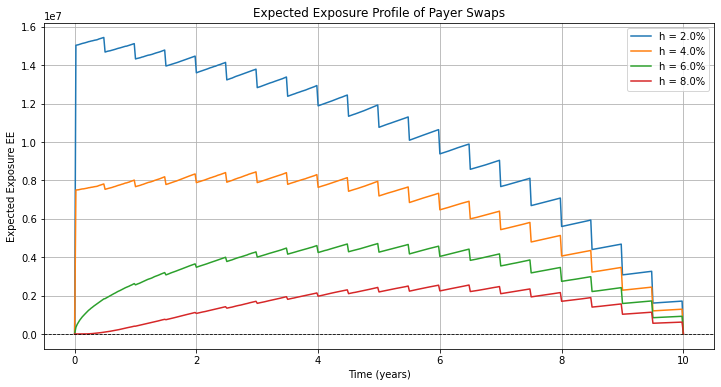

In [17]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_v_pay[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Expected Exposure Profile of Payer Swaps')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

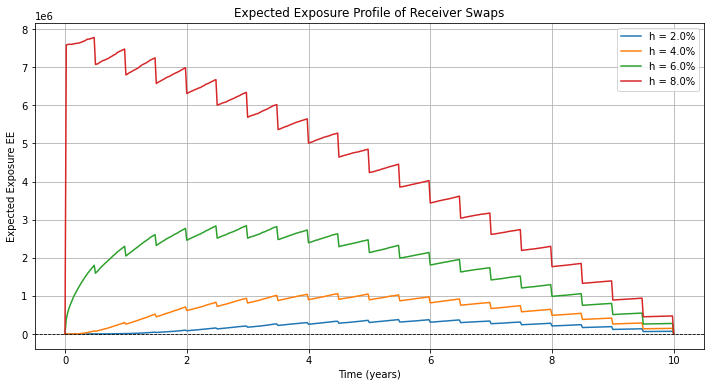

In [18]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_v_rec[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Expected Exposure Profile of Receiver Swaps')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

## Calculating the Present Value Expected Exposure of the Payer and Receiver Swaps

In [19]:
pv_rec_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}
pv_pay_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}

for i in range(num_paths):
    for j in range(1, num_steps + 1):

        for c in coupons:
            # PVE(t) = PV(t)+
            pv_pay_paths[c][i][j] = max(pvs_memory[i][j][c],0)
            pv_rec_paths[c][i][j] = max(-pvs_memory[i][j][c],0)

In [20]:
E_pv_rec = {c:0 for c in coupons}
E_pv_pay = {c:0 for c in coupons}

for c in coupons:
    # PVEE(t) = expectation(PVE(t))
    E_pv_rec[c] = np.mean(pv_rec_paths[c],axis = 0)
    E_pv_pay[c] = np.mean(pv_pay_paths[c],axis = 0)

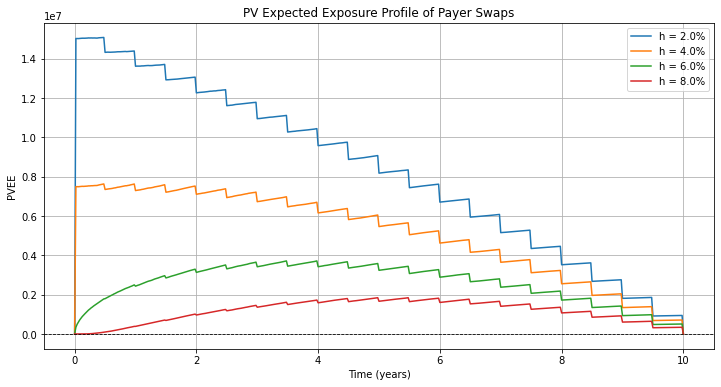

In [21]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_pv_pay[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('PV Expected Exposure Profile of Payer Swaps')
plt.xlabel('Time (years)')
plt.ylabel('PVEE')
plt.legend()
plt.grid(True)
plt.show()

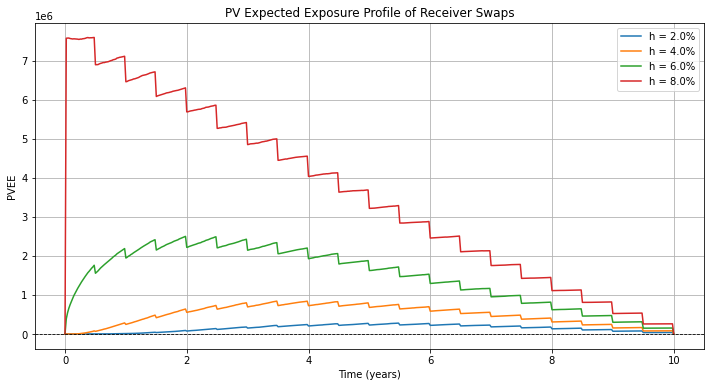

In [22]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_pv_rec[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('PV Expected Exposure Profile of Receiver Swaps')
plt.xlabel('Time (years)')
plt.ylabel('PVEE')
plt.legend()
plt.grid(True)
plt.show()

## Now, we consider a Collaterized Swap. 
### Plotting the Expected Exposure Profiles for the same.

In [57]:
v_coll_rec_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}
v_coll_pay_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}

for i in range(num_paths):
    for j in range(1, num_steps + 1):
        
        for c in coupons:
            
            # E(t) = (V(t) - V(t-δ))+
            v_coll_pay_paths[c][i][j] = max(vs_memory[i][j][c] - vs_memory[i][j-2][c],0)
            v_coll_rec_paths[c][i][j] = max(-vs_memory[i][j][c] + vs_memory[i][j-2][c],0)

In [58]:
E_v_coll_rec = {c:0 for c in coupons}
E_v_coll_pay = {c:0 for c in coupons}

for c in coupons:
    #EE(t) = expectation(E(t)) for Full Variation Margin
    E_v_coll_rec[c] = np.mean(v_coll_rec_paths[c],axis = 0)
    E_v_coll_pay[c] = np.mean(v_coll_pay_paths[c],axis = 0)

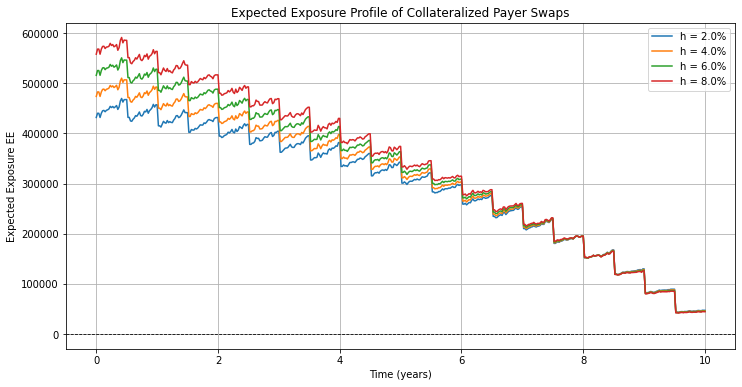

In [59]:
plt.figure(figsize=(12, 6))
for c in coupons:
    pt, = plt.plot(time_grid, E_v_coll_pay[c], label='h = {}%'.format(c*100))
    
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Expected Exposure Profile of Collateralized Payer Swaps')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

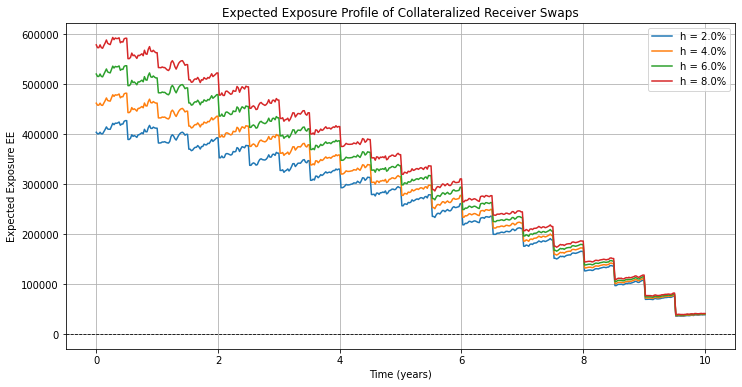

In [60]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_v_coll_rec[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Expected Exposure Profile of Collateralized Receiver Swaps')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
pv_coll_rec_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}
pv_coll_pay_paths = {c:np.zeros((num_paths, num_steps + 1)) for c in coupons}

for i in range(num_paths):
    for j in range(1, num_steps + 1):
        
        for c in coupons:
            
            # PVE(t) = (PV(t) - PV(t-δ))+
            pv_coll_pay_paths[c][i][j] = max(pvs_memory[i][j][c] - pvs_memory[i][j-2][c],0)
            pv_coll_rec_paths[c][i][j] = max(-pvs_memory[i][j][c] + pvs_memory[i][j-2][c],0)

In [62]:
E_pv_coll_rec = {c:0 for c in coupons}
E_pv_coll_pay = {c:0 for c in coupons}

for c in coupons:
    #PVEE(t) = expectation(PVE(t)) for Full Variation Margin
    E_pv_coll_rec[c] = np.mean(pv_coll_rec_paths[c],axis = 0)
    E_pv_coll_pay[c] = np.mean(pv_coll_pay_paths[c],axis = 0)

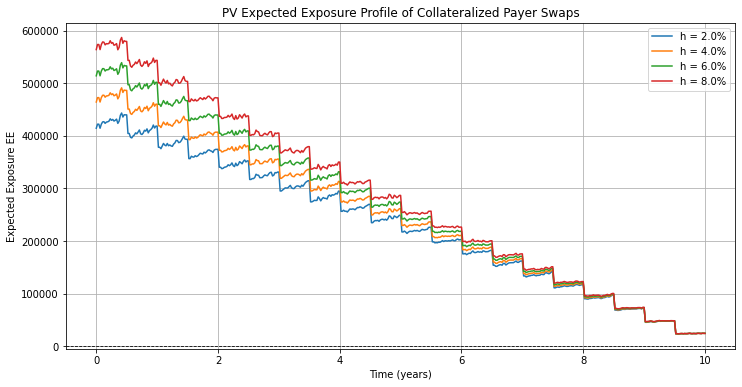

In [63]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_pv_coll_pay[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('PV Expected Exposure Profile of Collateralized Payer Swaps')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

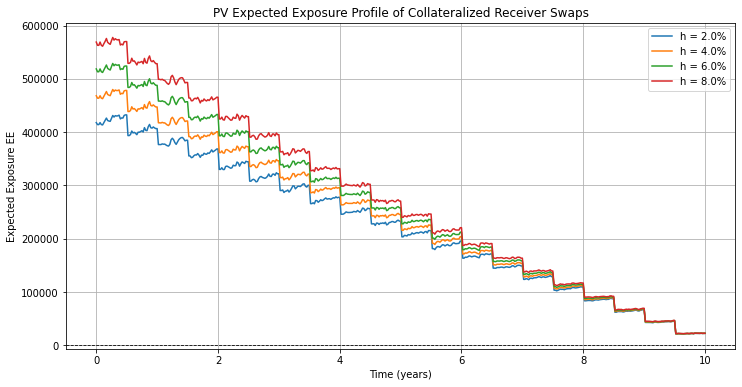

In [64]:
plt.figure(figsize=(12, 6))
for c in coupons:
    plt.plot(time_grid, E_pv_coll_rec[c], label='h = {}%'.format(c*100))
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('PV Expected Exposure Profile of Collateralized Receiver Swaps')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

## Considering multiple values of h

In [31]:
from scipy.special import ndtri
from scipy.stats import norm

def ohm_p(p):
    
    norm_inv_p = ndtri(p)
    
    
    return (norm.pdf(norm_inv_p,0,1) - norm_inv_p*(1-p)) * ((2*math.pi)**0.5)

In [32]:
vs_hpar_memory = {}
pvs_hpar_memory = {}
 
for i in range(num_paths):

    vs_hpar_memory[i] = {0:0,-1:0}
    pvs_hpar_memory[i] = {0:0,-1:0}
    
    for j in range(1, num_steps + 1):

        vs, pvs = swapvalue([h_par], couponPeriods, x1_values[i][j], x2_values[i][j], dt, j*dt, 0.5, notional_val)
        vs_hpar_memory[i][j] = vs[h_par]
        pvs_hpar_memory[i][j] = pvs[h_par]

In [65]:
v_q4_pay_paths = np.zeros((num_paths, num_steps + 1))


for i in range(num_paths):
    for j in range(1, num_steps + 1):

        # E(t) = (V(t) - V(t-δ))+
        v_q4_pay_paths[i][j] = max(vs_hpar_memory[i][j] - vs_hpar_memory[i][j-2],0)

In [66]:
#EE*(t) = expectation(E(t)) for Full Variation Margin
E_v_q4_pay_star = np.mean(v_q4_pay_paths,axis = 0)

In [67]:
p_list = [0.8,0.9,0.99,0.999]
E_v_q4_pay = {}
for p in p_list:
    #EE(t) = EE*(t)*Ω(p) for Full Variation Margin and Ininital margin at level p(%)
    E_v_q4_pay[p] = E_v_q4_pay_star * ohm_p(p)
    

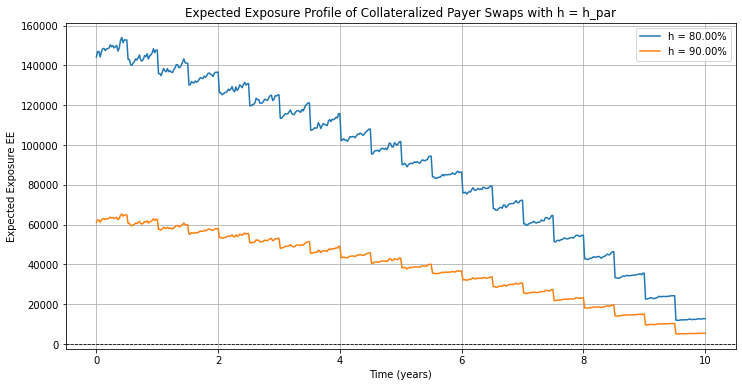

In [68]:
plt.figure(figsize=(12, 6))

for p in p_list[:2]:
    plt.plot(time_grid, E_v_q4_pay[p], label='h = {:.2f}%'.format(p*100))
    
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Expected Exposure Profile of Collateralized Payer Swaps with h = h_par')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

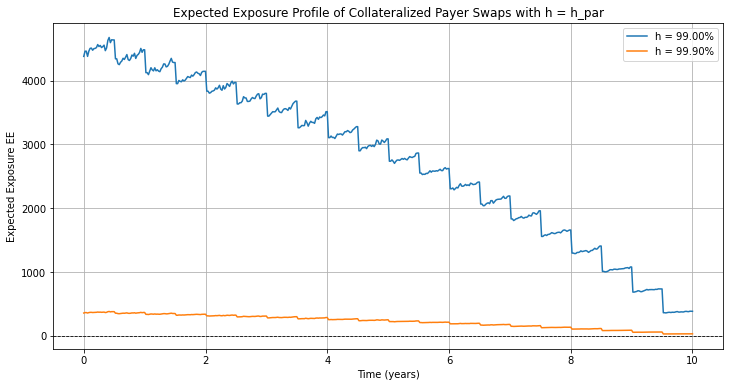

In [69]:
plt.figure(figsize=(12, 6))

for p in p_list[2:]:
    plt.plot(time_grid, E_v_q4_pay[p], label='h = {:.2f}%'.format(p*100))
    
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Expected Exposure Profile of Collateralized Payer Swaps with h = h_par')
plt.xlabel('Time (years)')
plt.ylabel('Expected Exposure EE')
plt.legend()
plt.grid(True)
plt.show()

## Calculating the Unilateral CVA using the PVEE and the survival probabilty calculated using Lambda

In [38]:
def calculate_x(lam):
    survival_probabilites = np.zeros(len(time_grid))
    
    for i, t in enumerate(time_grid):
        survival_probabilites[i] = math.exp(-lam * t)
       
    # Array of X(0,t_i)
    return survival_probabilites

In [39]:
def calculate_x_difference(survival_probabilites):
    difference = np.zeros(len(survival_probabilites))
    difference[0]=0-survival_probabilites[0]
    
    for i in range(0, len(survival_probabilites)):
        difference[i] = survival_probabilites[i] - survival_probabilites[i-1]
        
    # Array of X(0,t_i) and X(0,t_i-1)
    return difference

In [40]:
survival_probability_A = calculate_x(0.04)
difference_A = calculate_x_difference(survival_probability_A)

In [41]:
survival_probability_B = calculate_x(0.025)

In [42]:
def calculate_CVA(PVEE, RR, diff_X):
    
    return (RR - 1) * PVEE@diff_X.T

In [43]:
variations = ['No Collateral','Full Variation Margin', 'Full Variation Margin with Initial Margin at p=99%']

cva_pay = {v:{c:0 for c in coupons} for v in variations}
cva_rec = {v:{c:0 for c in coupons} for v in variations}

RA = 0.4
p = 0.99

for c in coupons:
    cva_pay['No Collateral'][c] = calculate_CVA(E_pv_pay[c],RA,difference_A)
    cva_rec['No Collateral'][c] = calculate_CVA(E_pv_rec[c],RA,difference_A)
    
    cva_pay['Full Variation Margin'][c] = calculate_CVA(E_pv_coll_pay[c],RA,difference_A)
    cva_rec['Full Variation Margin'][c] = calculate_CVA(E_pv_coll_rec[c],RA,difference_A)
    
    cva_pay['Full Variation Margin with Initial Margin at p=99%'][c] = calculate_CVA(E_pv_coll_pay[c] * ohm_p(p),RA,difference_A)
    cva_rec['Full Variation Margin with Initial Margin at p=99%'][c] = calculate_CVA(E_pv_coll_rec[c] * ohm_p(p),RA,difference_A)
    

In [44]:
cva_pay_df = pd.DataFrame.from_dict(cva_pay)
cva_rec_df = pd.DataFrame.from_dict(cva_rec)

In [45]:
cva_df = pd.concat([cva_pay_df, cva_rec_df], axis=1, keys=['Payer Swap', 'Receiver Swap'])
cva_df.index = cva_df.index*100
cva_df.index.name = 'Coupon (%)'
cva_df

Payer Swap                        \
           No Collateral Full Variation Margin   
Coupon (%)                                       
2.0         1.744698e+06          60646.279803   
4.0         1.062303e+06          58190.321028   
6.0         5.183307e+05          57102.621571   
8.0         2.254437e+05          63576.248858   

                                                               Receiver Swap  \
           Full Variation Margin with Initial Margin at p=99%  No Collateral   
Coupon (%)                                                                     
2.0                                                515.136757   28002.735827   
4.0                                                494.275549   96909.519161   
6.0                                                485.036500  304238.004468   
8.0                                                540.024265  762652.111156   

                                  \
           Full Variation Margin   
Coupon (%)                         
2.0                 57484.977551   
4.0                 56372.048351   
6.0                 56627.378468   
8.0                 64444.035330   

                                                               
           Full Variation Margin with Initial Margin at p=99%  
Coupon (%)                                                     
2.0                                                488.284277  
4.0                                                478.830924  
6.0                                                480.999728  
8.0                                                547.395347

With a higher magnitude of CVA we can interpret it as a higher credit exposure. Thus the numbers decrease as we go through the different types of scenarios.

No Collateral : the highest of each row because the lack of collateral makes the exposure higher.                               

Full variation Margin: The second highest value is in case of a Variation Margin scenario this is because with the variation margin payments there is a reduction in Potential Exposure.

Full Variation Margin with Initial Margin : The least value of the CVA.

## Calculating the Bilateral CVA using the same parameters

In [46]:
def calculate_bilateral_CVA(PVEE, RR, diff_X_A, X_B):
    
    return (RR - 1) * PVEE@(survival_probability_B*difference_A).T

In [47]:
variations = ['No Collateral','Full Variation Margin', 'Full Variation Margin with Initial Margin at p=99%']

cva_bilateral_pay = {v:{c:0 for c in coupons} for v in variations}
cva_bilateral_rec = {v:{c:0 for c in coupons} for v in variations}

RA = 0.4
p = 0.99

for c in coupons:
    cva_bilateral_pay['No Collateral'][c] = calculate_bilateral_CVA(E_pv_pay[c],RA,difference_A,survival_probability_B)
    cva_bilateral_rec['No Collateral'][c] = calculate_bilateral_CVA(E_pv_rec[c],RA,difference_A,survival_probability_B)
    
    cva_bilateral_pay['Full Variation Margin'][c] = calculate_bilateral_CVA(E_pv_coll_pay[c],RA,difference_A,survival_probability_B)
    cva_bilateral_rec['Full Variation Margin'][c] = calculate_bilateral_CVA(E_pv_coll_rec[c],RA,difference_A,survival_probability_B)
    
    cva_bilateral_pay['Full Variation Margin with Initial Margin at p=99%'][c] = calculate_bilateral_CVA(E_pv_coll_pay[c] * ohm_p(p),RA,difference_A,survival_probability_B)
    cva_bilateral_rec['Full Variation Margin with Initial Margin at p=99%'][c] = calculate_bilateral_CVA(E_pv_coll_rec[c] * ohm_p(p),RA,difference_A,survival_probability_B)
    

In [48]:
cva_bilateral_pay_df = pd.DataFrame.from_dict(cva_bilateral_pay)
cva_bilateral_rec_df = pd.DataFrame.from_dict(cva_bilateral_rec)

In [49]:
cva_bilateral_df = pd.concat([cva_bilateral_pay_df, cva_bilateral_rec_df], axis=1, keys=['Payer Swap', 'Receiver Swap'])
cva_bilateral_df.index = cva_bilateral_df.index*100
cva_bilateral_df.index.name = 'Coupon (%)'
cva_bilateral_df

Payer Swap                        \
           No Collateral Full Variation Margin   
Coupon (%)                                       
2.0         1.608752e+06          57111.552038   
4.0         9.729579e+05          54324.546538   
6.0         4.666576e+05          52821.742257   
8.0         1.988415e+05          58782.751146   

                                                               Receiver Swap  \
           Full Variation Margin with Initial Margin at p=99%  No Collateral   
Coupon (%)                                                                     
2.0                                                485.112356   24539.154154   
4.0                                                461.439198   86680.727547   
6.0                                                448.674199  278316.244914   
8.0                                                499.307722  708435.923162   

                                  \
           Full Variation Margin   
Coupon (%)                         
2.0                 52591.294862   
4.0                 51763.512205   
6.0                 52219.930767   
8.0                 60140.162499   

                                                               
           Full Variation Margin with Initial Margin at p=99%  
Coupon (%)                                                     
2.0                                                446.716751  
4.0                                                439.685466  
6.0                                                443.562340  
8.0                                                510.837736

## Calculating the FVA 

In [50]:
difference_B = calculate_x_difference(survival_probability_B)

In [51]:
def calculate_FVA(PVEE_plus, PVEE_minus, RR, diff_X_B):
    
    FCA = (RR - 1) * PVEE_plus@diff_X_B.T
    FBA = (RR - 1) * PVEE_minus@diff_X_B.T
    
    return FCA - FBA

In [52]:
Sb = 0.015
lamda_b = 0.025
# Sb = λb * (1 - Rb)
RB = 1 - Sb/lamda_b

fva = {'Payer Swap':{c:0 for c in coupons},'Receiver Swap':{c:0 for c in coupons}}

for c in coupons:
    
    fva['Payer Swap'][c] = calculate_FVA(E_pv_pay[c], E_pv_rec[c], RB, difference_B)
    fva['Receiver Swap'][c] = -fva['Payer Swap'][c]
    

In [53]:
fva_df = pd.DataFrame.from_dict(fva)
fva_df.index = fva_df.index*100
fva_df.index.name = 'Coupon (%)'
fva_df

,Payer Swap,Receiver Swap
Coupon (%),,
2.0,1.127628e+06,-1.127628e+06
4.0,6.361601e+05,-6.361601e+05
6.0,1.446919e+05,-1.446919e+05
8.0,-3.467762e+05,3.467762e+05


The negative FVA values highlight scenarios where the funding benefits (or reduced costs) associated with the fixed cash flows of the swaps outweigh the funding costs for the other party, resulting in a net benefit for one of the counterparties.

The negative numbers in the FVA values suggest that, for certain coupon rates, the funding benefit for one party (Payer or Receiver) outweighs the funding cost for the other party, resulting in a net benefit for the payer or receiver.

In our case we see that the Payer Swap has negative FVA value only in case of the 8% coupon and the complimentary signs in case of the corresponding Receiver swap.

## Calculating the MVA

In [54]:
def calculate_MVA(PVEE, RR, diff_X_B, p):
    
    return ((2*math.pi)**0.5) * ndtri(p) * (RR - 1) * PVEE@diff_X_B.T

In [55]:
mva = {'Payer Swap':{c:0 for c in coupons},'Receiver Swap':{c:0 for c in coupons}}
p = 0.99

for c in coupons:
    
    mva['Payer Swap'][c] = calculate_MVA(E_pv_pay[c], RB, difference_B, p)
    mva['Receiver Swap'][c] = calculate_MVA(E_pv_rec[c], RB, difference_B, p)
   

In [56]:
mva_df = pd.DataFrame.from_dict(mva)
mva_df.index = mva_df.index*100
mva_df.index.name = 'Coupon (%)'
mva_df

,Payer Swap,Receiver Swap
Coupon (%),,
2.0,6.686112e+06,1.105849e+05
4.0,4.087732e+06,3.780984e+05
6.0,2.015008e+06,1.171268e+06
8.0,8.870725e+05,2.909225e+06


MVA is a cost associated with maintaining a prudent level of collateral to manage potential risks. Shareholders benefit from a company's commitment to risk management, even if it involves certain costs. Looking at the calculation and the values generated through the simulation we see that the MVA is a certain multiple of CVA. Therefore, we need the calculated values of Margin.